In [1]:
#https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/
#https://keras.io/examples/vision/pointnet/
#https://stackoverflow.com/questions/66845924/multi-input-multi-output-model-with-keras-functional-api

In [1]:
#imports
import os
import sys
import shutil
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse
from spektral.data.graph import Graph
from keras.models import Model
from keras.layers import Dense, Dropout, Concatenate, Reshape, Add, BatchNormalization, Activation, Conv2D, Conv1D, Input, concatenate
from spektral.layers import GCNConv, GlobalMaxPool, CensNetConv, GATConv, DiffusionConv, ARMAConv, GlobalAvgPool, GINConvBatch, GCSConv
from spektral.data import BatchLoader, DisjointLoader
from spektral.data import Dataset
from spektral.transforms import GCNFilter, NormalizeAdj
from keras.models import Model
from tqdm import tqdm
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow import keras
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
import keras_tuner as kt
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from spektral.data.utils import to_tf_signature, prepend_none
import visualkeras

In [2]:
#Thingi10k data
#Read data, drop unnecessary
data = pd.read_csv('thingi10k_data.csv', index_col=0)
df = data.copy()
df.drop("source", axis=1, inplace=True)
df.drop("model_name", axis=1, inplace=True)

#Extract build times
dfcopy = df.copy()
build_times = df["build_time"]
df.drop("build_time", axis=1,inplace=True)
df.drop("support_material", axis=1, inplace=True)

#Make pipeline
#https://joaquinamatrodrigo.github.io/skforecast/0.5.1/user_guides/sklearn-transformers-and-pipeline.html

def log_transform(x):
    return np.log(x + 1)

def inv_log_transform(x):
    return np.exp(x) - 1 

#normalizer = Normalizer()
#scaler = MinMaxScaler()
logtransformer = FunctionTransformer(func=log_transform, inverse_func=inv_log_transform, check_inverse=False)
pipe = Pipeline(steps=[ ('logtransformer', logtransformer)])

#Train test split
xtrain = df[:3000]
xtest = df[3000:3600]
ytrain = build_times[:3000]
ytest = build_times[3000:3600]

xlabels = xtrain.columns.values

#Fit pipeline
xtrain = pipe.fit_transform(xtrain)
xtrain = pd.DataFrame(xtrain)
xtrain.columns = xlabels

xtest = pipe.transform(xtest)
xtest = pd.DataFrame(xtest)
xtest.columns = xlabels

#Convert to tensors
xtraint = tf.convert_to_tensor(xtrain)
ytraint = tf.convert_to_tensor(ytrain)
xtestt = tf.convert_to_tensor(xtest)
ytestt = tf.convert_to_tensor(ytest)

In [3]:
#Custom disjointloader
def getFeatures(batch):
    feats = []
    for graph in batch:
        feats.append(graph.__getattribute__('feats'))
    return np.array(feats)

class MyDisjointLoader(DisjointLoader):
    def __init__(
        self, dataset, node_level=False, batch_size=1, epochs=None, shuffle=True
    ):
        self.node_level = node_level
        super().__init__(dataset, batch_size=batch_size, epochs=epochs, shuffle=shuffle)

    def __next__(self):
        nxt = self._generator.__next__()
        feats = getFeatures(nxt)
        #feats = nxt[0].__getattribute__('feats')
        output, y = self.collate(nxt)
        feats = (feats,)
        output = output + feats
        return   output, y
    
    def tf_signature(self):
    
        signature = self.dataset.signature
        if "y" in signature:
            signature["y"]["shape"] = prepend_none(signature["y"]["shape"])
        if "a" in signature:
            signature["a"]["spec"] = tf.SparseTensorSpec

        signature["i"] = dict()
        signature["i"]["spec"] = tf.TensorSpec
        signature["i"]["shape"] = (None,)
        signature["i"]["dtype"] = tf.as_dtype(tf.int64)

        sig = (tf.TensorSpec(shape=[None,12]),)
        input = to_tf_signature(signature)
        sig = input[0] + sig
        return (sig, input[1])

In [4]:
#Graph data
features = pd.read_csv('thingi10k_data.csv', index_col=0)
adjpath = '../Data/stl/adjacency_stl_simplified/'
cloudpath = '../Data/stl/nodefeatures_stl_simplified/'
edgepath = '../Data/stl/edgefeaturesmatrix_stl_simplified/'

build_times = []

class MyDataset(Dataset):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def read(self):
        output = []

        for i in range(3000):
            if(os.path.isfile(adjpath + f'{features["model_name"][i]}.npz')):
                adjmatrix = scipy.sparse.load_npz(adjpath + f'{features["model_name"][i]}.npz')
                point_cloud = np.load(cloudpath + f'{features["model_name"][i]}.npy').reshape(-1,3)
                edgefeat = scipy.sparse.load_npz(edgepath + f'{features["model_name"][i]}.npz')
                output.append(
                    Graph(x=point_cloud, a=edgefeat, y=features["build_time"][i], feats=xtraint[i])
                )

        return output
    
dataset = MyDataset()

class TestDataset(Dataset):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def read(self):
        output = []

        #files = os.listdir("../Data/adjmatrices/")
        for i in range(3000,3600):
            if(os.path.isfile(adjpath + f'{features["model_name"][i]}.npz')):
                adjmatrix = scipy.sparse.load_npz(adjpath + f'{features["model_name"][i]}.npz')
                point_cloud = np.load(cloudpath + f'{features["model_name"][i]}.npy').reshape(-1,3)
                edgefeat = scipy.sparse.load_npz(edgepath + f'{features["model_name"][i]}.npz')
                output.append(
                    Graph(x=point_cloud, a=edgefeat, y=features["build_time"][i], feats=xtestt[i-3000])
                )

        return output
    
testdataset = TestDataset()

#Preprocessing
#dataset.apply(GCNFilter())
#testdataset.apply(GCNFilter())
dataset.apply(NormalizeAdj())
testdataset.apply(NormalizeAdj())
dataset

MyDataset(n_graphs=3000)

In [18]:
keras.backend.clear_session()

In [42]:
to_tf_signature(testdataset.signature)

((TensorSpec(shape=(None, 3), dtype=tf.float64, name=None),
  SparseTensorSpec(TensorShape([None, None]), tf.float64)),
 TensorSpec(shape=(1,), dtype=tf.int64, name=None))

In [72]:
batch = testloader.__next__()
batch[0]

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


(array([[ 41.        , 200.        ,   0.        ],
        [ 25.        , 200.        ,   0.        ],
        [ 25.        , 242.        ,   0.        ],
        ...,
        [ 41.        , 228.57106018,  29.91878319],
        [ 41.        , 215.29289246,  38.70710754],
        [ 41.        , 215.13397217,  38.5       ]]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       

In [5]:
#NN Model
'''inputs = Input(name='features input', type_spec=tf.TensorSpec(shape=(None, 13)))
x = Dense(104, activation='relu')(inputs)
x = Dense(8, activation='relu')(x)
x = Dense(8, activation='relu')(x)
x = Dense(8, activation='relu')(x)
x = Dense(1, activation='linear')(x)
nnmodel = Model(inputs, x)'''

nnmodel = keras.models.load_model('savedmodels/Baseline_nosupp_final')
for layer in nnmodel.layers:
    layer.trainable = False

In [6]:
nnmodel.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 12)               25        
 ion)                                                            
                                                                 
 dense_15 (Dense)            (None, 8)                 104       
                                                                 
 dense_16 (Dense)            (None, 24)                216       
                                                                 
 dense_17 (Dense)            (None, 136)               3400      
                                                                 
 dense_18 (Dense)            (None, 232)               31784     
                                                                 
 dense_19 (Dense)            (None, 232)               54056     
                                                      

In [9]:
#GCN Model
#gcnmodel = keras.models.load_model('savedmodels/GCN_simplified')
gcnmodel = keras.models.load_model('savedmodels/GCNmodel_final')
for layer in gcnmodel.layers:
    layer.trainable = False

In [8]:
gcnmodel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputx (InputLayer)            [(None, 3)]          0           []                               
                                                                                                  
 inputa (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 gcs_conv (GCSConv)             (None, 128)          896         ['inputx[0][0]',                 
                                                                  'inputa[0][0]']                 
                                                                                                  
 gcs_conv_1 (GCSConv)           (None, 256)          65792       ['gcs_conv[0][0]',           

In [27]:
gcnmodel.get_layer('dense_3')._name = 'dense_a'
gcnmodel.get_layer('dense_4')._name = 'dense_b'
gcnmodel.get_layer('dense_5')._name = 'dense_c'

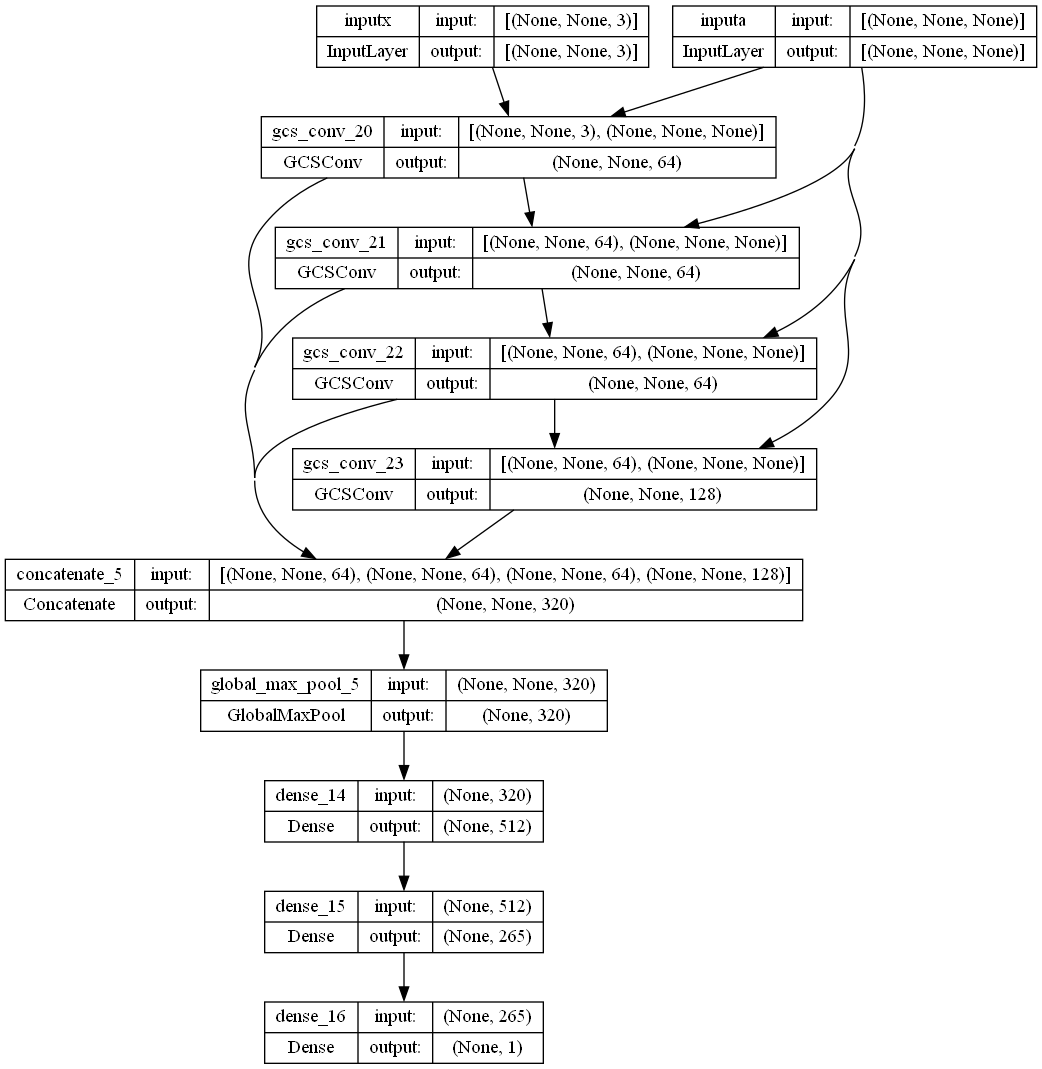

In [12]:
keras.utils.plot_model(gcnmodel, "savedimages/gcnmodel.png", show_shapes=True)

In [10]:
#concatenate
combined = concatenate([nnmodel.get_layer('dropbaseline').output, gcnmodel.get_layer('dropgcn').output], name='join')
#z = Dense(512,'relu', name='dense1')(combined)
z = Dense(128,'relu', name='dense1')(combined)
#z = Dense(512,'relu', name='dense2')(z)
#z = Dense(128,'relu', name='dense3')(z)
z = Dense(64,'relu', name='dense4')(z)
z = Dropout(0.2, name='finaldrop')(z)
z = Dense(1, 'linear', name='regress')(z)
model = Model(inputs = [gcnmodel.input, nnmodel.input], outputs = z)

In [29]:
model.input

[[<KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'inputx')>,
  <KerasTensor: type_spec=SparseTensorSpec(TensorShape([None, None]), tf.float32) (created by layer 'inputa')>,
  <KerasTensor: shape=(None,) dtype=int32 (created by layer 'inputi')>],
 <KerasTensor: shape=(None, 12) dtype=float32 (created by layer 'baselineinput')>]

In [11]:
model.name

'model'

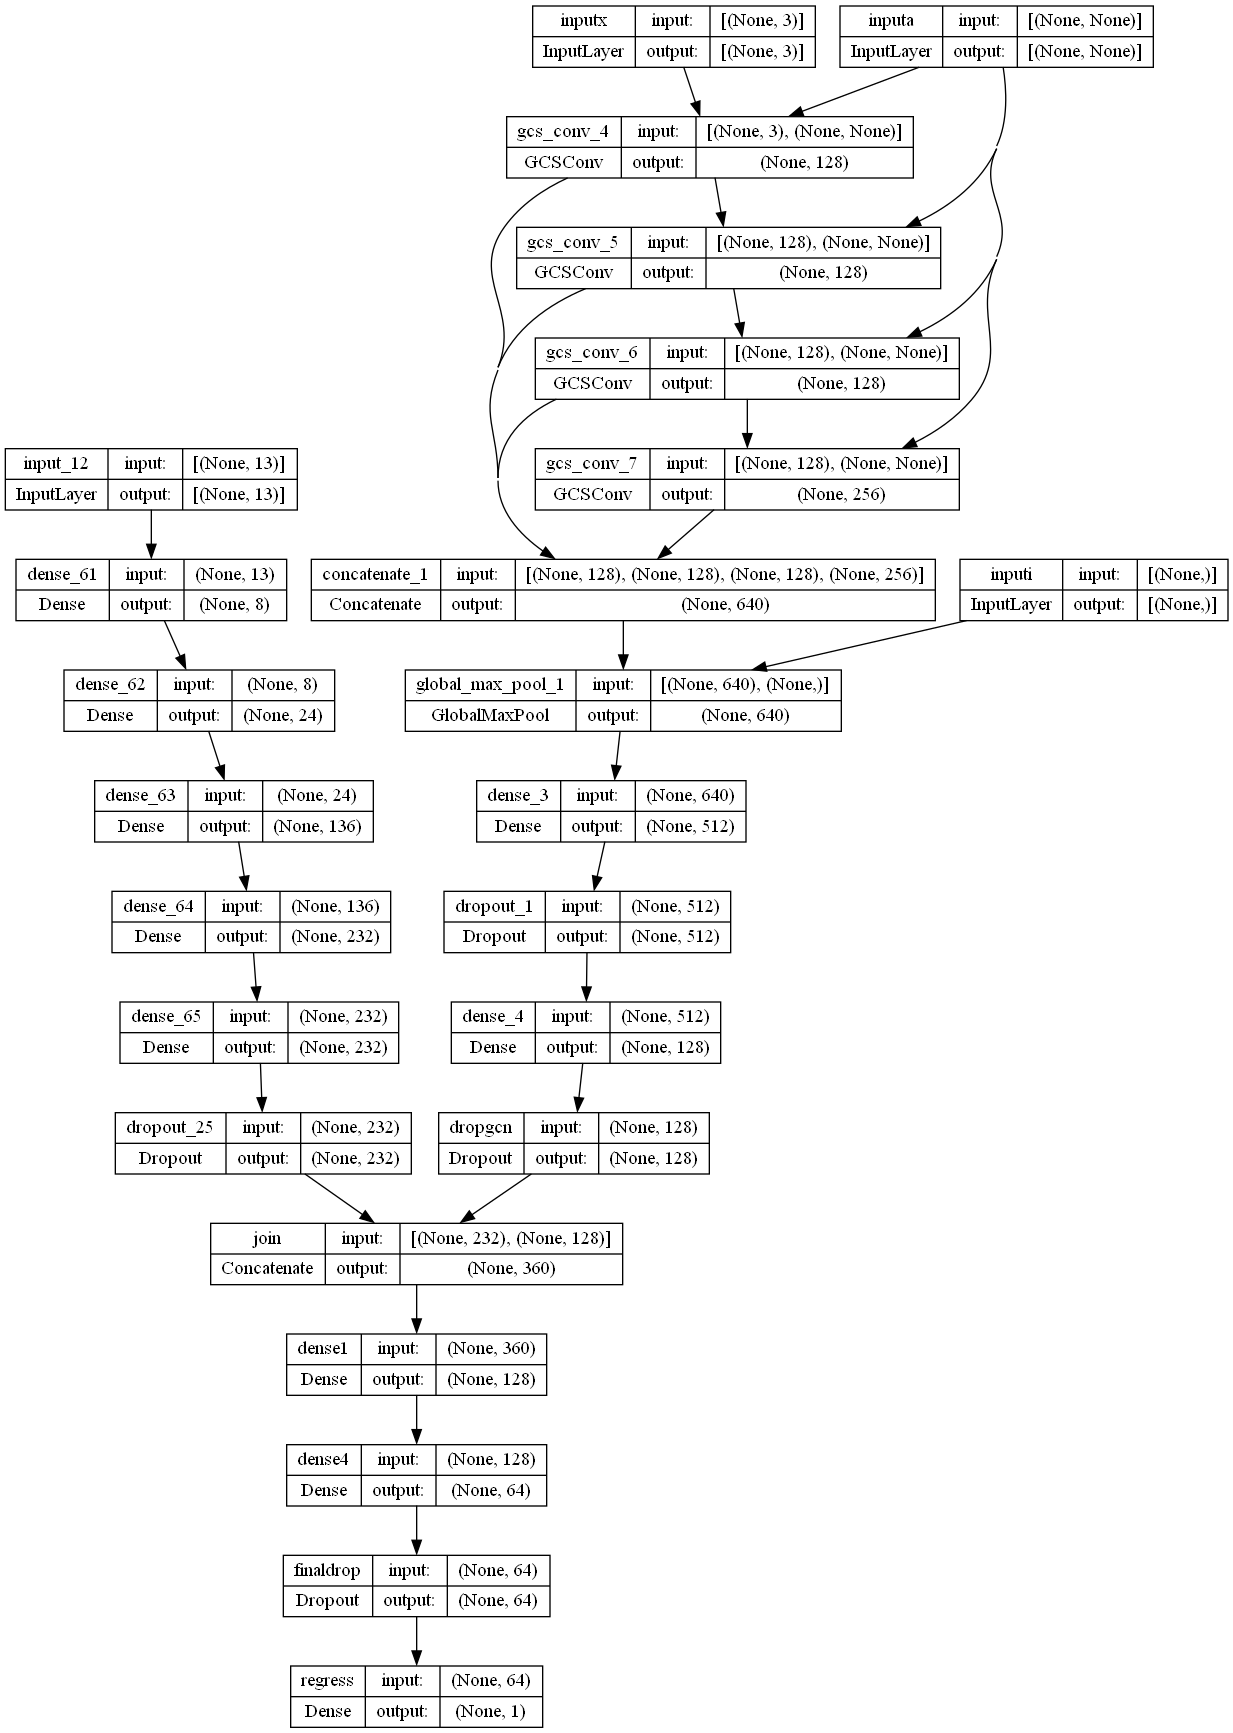

In [17]:
keras.utils.plot_model(model, "savedimages/multi_inputmodel.png", show_shapes=True)

In [5]:
#Define callbacks
def get_callbacks(weights_file, patience, lr_factor):
  return [
      # Only save the weights that correspond to the minimum mape.
      ModelCheckpoint(filepath= weights_file,
                      monitor="val_mape", 
                      mode="min",
                      save_best_only=True, 
                      save_weights_only=False),
      # If val_loss doesn't improve for a number of epochs set with 'patience' var 
      # training will stop to avoid overfitting.    
      EarlyStopping(monitor="val_loss",
                    mode="min",
                    patience = patience,
                    verbose=1),
      # Learning rate is reduced by 'lr_factor' if val_loss stagnates
      # for a number of epochs set with 'patience/2' var.     
      ReduceLROnPlateau(monitor="val_loss", mode="min",
                        factor=lr_factor, min_lr=1e-8, patience=patience//2, verbose=1)]

In [ ]:
#Reset weights
def reset_weights(model):
    import keras.backend as K
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel.initializer'): 
            layer.kernel.initializer.run(session=session)
        if hasattr(layer, 'bias.initializer'):
            layer.bias.initializer.run(session=session)  

In [12]:
reset_weights(model)

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001) , loss='mape', metrics=[tf.keras.metrics.MeanAbsolutePercentageError(name="mape"), 'mae'])

In [6]:
loader = MyDisjointLoader(dataset, batch_size=1)
testloader = MyDisjointLoader(testdataset, batch_size=1)

In [14]:
history = model.fit(loader.load(), validation_data=testloader.load(), validation_steps=testloader.steps_per_epoch, steps_per_epoch=loader.steps_per_epoch, epochs=1000, verbose=2, callbacks=get_callbacks('savedmodels/Multi_input_nosupp_final+',patience=50,lr_factor=0.3))

Epoch 1/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


3000/3000 - 45s - loss: 32.3098 - mape: 31.4647 - mae: 92.3995 - val_loss: 28.5528 - val_mape: 27.6982 - val_mae: 97.7421 - lr: 0.0010 - 45s/epoch - 15ms/step
Epoch 2/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


3000/3000 - 44s - loss: 31.8009 - mape: 30.9465 - mae: 83.8889 - val_loss: 30.5604 - val_mape: 29.7267 - val_mae: 73.2220 - lr: 0.0010 - 44s/epoch - 15ms/step
Epoch 3/1000
3000/3000 - 44s - loss: 32.5865 - mape: 31.7867 - mae: 88.3370 - val_loss: 28.6998 - val_mape: 27.9294 - val_mae: 131.5721 - lr: 0.0010 - 44s/epoch - 15ms/step
Epoch 4/1000
3000/3000 - 43s - loss: 31.4480 - mape: 30.7027 - mae: 90.5677 - val_loss: 39.3451 - val_mape: 38.6339 - val_mae: 84.8995 - lr: 0.0010 - 43s/epoch - 14ms/step
Epoch 5/1000


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


3000/3000 - 44s - loss: 31.1339 - mape: 30.4496 - mae: 83.0099 - val_loss: 22.9242 - val_mape: 22.2607 - val_mae: 68.7463 - lr: 0.0010 - 44s/epoch - 15ms/step
Epoch 6/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


3000/3000 - 43s - loss: 30.8583 - mape: 30.2392 - mae: 81.4230 - val_loss: 48.7750 - val_mape: 48.1986 - val_mae: 288.9778 - lr: 0.0010 - 43s/epoch - 14ms/step
Epoch 7/1000
3000/3000 - 42s - loss: 31.2783 - mape: 30.7110 - mae: 93.3327 - val_loss: 29.6249 - val_mape: 29.0629 - val_mae: 94.6489 - lr: 0.0010 - 42s/epoch - 14ms/step
Epoch 8/1000
3000/3000 - 43s - loss: 31.1298 - mape: 30.6061 - mae: 85.6332 - val_loss: 23.9860 - val_mape: 23.5026 - val_mae: 90.2747 - lr: 0.0010 - 43s/epoch - 14ms/step
Epoch 9/1000
3000/3000 - 44s - loss: 29.9637 - mape: 29.5146 - mae: 84.9279 - val_loss: 25.1561 - val_mape: 24.7405 - val_mae: 171.8071 - lr: 0.0010 - 44s/epoch - 15ms/step
Epoch 10/1000
3000/3000 - 44s - loss: 29.8092 - mape: 29.4174 - mae: 86.0928 - val_loss: 26.4337 - val_mape: 26.0653 - val_mae: 171.3357 - lr: 0.0010 - 44s/epoch - 15ms/step
Epoch 11/1000


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


3000/3000 - 49s - loss: 29.7260 - mape: 29.3745 - mae: 89.7073 - val_loss: 22.4348 - val_mape: 22.1106 - val_mae: 91.7022 - lr: 0.0010 - 49s/epoch - 16ms/step
Epoch 12/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


3000/3000 - 47s - loss: 29.3333 - mape: 29.0231 - mae: 86.4051 - val_loss: 21.9707 - val_mape: 21.6700 - val_mae: 93.4936 - lr: 0.0010 - 47s/epoch - 16ms/step
Epoch 13/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


3000/3000 - 47s - loss: 28.9851 - mape: 28.7017 - mae: 80.8264 - val_loss: 26.5896 - val_mape: 26.3102 - val_mae: 75.3321 - lr: 0.0010 - 47s/epoch - 16ms/step
Epoch 14/1000
3000/3000 - 46s - loss: 29.2600 - mape: 29.0054 - mae: 82.6535 - val_loss: 23.7943 - val_mape: 23.5673 - val_mae: 110.0190 - lr: 0.0010 - 46s/epoch - 15ms/step
Epoch 15/1000
3000/3000 - 47s - loss: 28.6593 - mape: 28.4417 - mae: 81.5706 - val_loss: 23.7452 - val_mape: 23.5383 - val_mae: 115.9744 - lr: 0.0010 - 47s/epoch - 16ms/step
Epoch 16/1000
3000/3000 - 48s - loss: 28.2071 - mape: 28.0159 - mae: 83.4259 - val_loss: 26.0302 - val_mape: 25.8589 - val_mae: 125.7086 - lr: 0.0010 - 48s/epoch - 16ms/step
Epoch 17/1000
3000/3000 - 47s - loss: 28.7637 - mape: 28.5981 - mae: 87.1516 - val_loss: 28.0725 - val_mape: 27.9082 - val_mae: 98.4031 - lr: 0.0010 - 47s/epoch - 16ms/step
Epoch 18/1000


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


3000/3000 - 48s - loss: 27.6347 - mape: 27.4853 - mae: 78.3958 - val_loss: 21.2216 - val_mape: 21.0782 - val_mae: 104.2966 - lr: 0.0010 - 48s/epoch - 16ms/step
Epoch 19/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


3000/3000 - 47s - loss: 27.0670 - mape: 26.9382 - mae: 72.0098 - val_loss: 28.8302 - val_mape: 28.7106 - val_mae: 104.8978 - lr: 0.0010 - 47s/epoch - 16ms/step
Epoch 20/1000
3000/3000 - 43s - loss: 28.3254 - mape: 28.2123 - mae: 78.3317 - val_loss: 26.0633 - val_mape: 25.9646 - val_mae: 78.1619 - lr: 0.0010 - 43s/epoch - 14ms/step
Epoch 21/1000
3000/3000 - 44s - loss: 28.3364 - mape: 28.2447 - mae: 84.4309 - val_loss: 31.5213 - val_mape: 31.4410 - val_mae: 95.4389 - lr: 0.0010 - 44s/epoch - 15ms/step
Epoch 22/1000
3000/3000 - 44s - loss: 26.7909 - mape: 26.7188 - mae: 80.9091 - val_loss: 30.4470 - val_mape: 30.3781 - val_mae: 89.0405 - lr: 0.0010 - 44s/epoch - 15ms/step
Epoch 23/1000
3000/3000 - 44s - loss: 27.5735 - mape: 27.5065 - mae: 77.5832 - val_loss: 21.7318 - val_mape: 21.6720 - val_mae: 128.4787 - lr: 0.0010 - 44s/epoch - 15ms/step
Epoch 24/1000
3000/3000 - 45s - loss: 26.8917 - mape: 26.8387 - mae: 72.5074 - val_loss: 21.7916 - val_mape: 21.7445 - val_mae: 89.5239 - lr: 0.001

INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


3000/3000 - 45s - loss: 26.6293 - mape: 26.5919 - mae: 73.4174 - val_loss: 20.3832 - val_mape: 20.3462 - val_mae: 118.8069 - lr: 0.0010 - 45s/epoch - 15ms/step
Epoch 29/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


3000/3000 - 43s - loss: 26.9242 - mape: 26.8916 - mae: 76.9993 - val_loss: 22.4161 - val_mape: 22.3904 - val_mae: 73.3785 - lr: 0.0010 - 43s/epoch - 14ms/step
Epoch 30/1000
3000/3000 - 43s - loss: 26.4411 - mape: 26.4185 - mae: 81.9273 - val_loss: 22.2552 - val_mape: 22.2334 - val_mae: 86.9109 - lr: 0.0010 - 43s/epoch - 14ms/step
Epoch 31/1000


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


3000/3000 - 45s - loss: 27.2660 - mape: 27.2435 - mae: 78.0321 - val_loss: 20.2149 - val_mape: 20.1947 - val_mae: 64.8328 - lr: 0.0010 - 45s/epoch - 15ms/step
Epoch 32/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


3000/3000 - 43s - loss: 26.2424 - mape: 26.2211 - mae: 72.6181 - val_loss: 30.4683 - val_mape: 30.4473 - val_mae: 112.7107 - lr: 0.0010 - 43s/epoch - 14ms/step
Epoch 33/1000
3000/3000 - 41s - loss: 25.8661 - mape: 25.8434 - mae: 76.7722 - val_loss: 20.9661 - val_mape: 20.9467 - val_mae: 96.6826 - lr: 0.0010 - 41s/epoch - 14ms/step
Epoch 34/1000


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


3000/3000 - 45s - loss: 26.4068 - mape: 26.3805 - mae: 73.2973 - val_loss: 19.6580 - val_mape: 19.6232 - val_mae: 105.7491 - lr: 0.0010 - 45s/epoch - 15ms/step
Epoch 35/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


3000/3000 - 44s - loss: 24.7515 - mape: 24.7143 - mae: 65.8235 - val_loss: 30.3352 - val_mape: 30.3003 - val_mae: 137.9296 - lr: 0.0010 - 44s/epoch - 15ms/step
Epoch 36/1000
3000/3000 - 44s - loss: 25.9584 - mape: 25.9238 - mae: 72.1801 - val_loss: 20.9415 - val_mape: 20.9078 - val_mae: 117.9050 - lr: 0.0010 - 44s/epoch - 15ms/step
Epoch 37/1000
3000/3000 - 44s - loss: 26.0262 - mape: 25.9931 - mae: 74.2610 - val_loss: 23.9192 - val_mape: 23.8830 - val_mae: 77.6037 - lr: 0.0010 - 44s/epoch - 15ms/step
Epoch 38/1000
3000/3000 - 43s - loss: 26.7917 - mape: 26.7614 - mae: 74.5636 - val_loss: 23.1900 - val_mape: 23.1588 - val_mae: 111.1710 - lr: 0.0010 - 43s/epoch - 14ms/step
Epoch 39/1000
3000/3000 - 44s - loss: 26.2344 - mape: 26.2083 - mae: 71.6920 - val_loss: 21.3427 - val_mape: 21.3192 - val_mae: 79.7208 - lr: 0.0010 - 44s/epoch - 15ms/step
Epoch 40/1000
3000/3000 - 42s - loss: 25.6367 - mape: 25.6165 - mae: 70.5636 - val_loss: 27.0828 - val_mape: 27.0577 - val_mae: 74.3004 - lr: 0.00

INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


3000/3000 - 45s - loss: 25.6390 - mape: 25.6185 - mae: 72.5618 - val_loss: 18.6793 - val_mape: 18.6591 - val_mae: 65.0311 - lr: 0.0010 - 45s/epoch - 15ms/step
Epoch 42/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


3000/3000 - 44s - loss: 25.7729 - mape: 25.7519 - mae: 74.1507 - val_loss: 24.7019 - val_mape: 24.6790 - val_mae: 138.7491 - lr: 0.0010 - 44s/epoch - 15ms/step
Epoch 43/1000
3000/3000 - 44s - loss: 25.2527 - mape: 25.2343 - mae: 75.7904 - val_loss: 21.5157 - val_mape: 21.4970 - val_mae: 52.6524 - lr: 0.0010 - 44s/epoch - 15ms/step
Epoch 44/1000
3000/3000 - 43s - loss: 25.3219 - mape: 25.3035 - mae: 62.7541 - val_loss: 22.2971 - val_mape: 22.2817 - val_mae: 83.7606 - lr: 0.0010 - 43s/epoch - 14ms/step
Epoch 45/1000
3000/3000 - 42s - loss: 25.5168 - mape: 25.4999 - mae: 68.2863 - val_loss: 31.2680 - val_mape: 31.2537 - val_mae: 166.4284 - lr: 0.0010 - 42s/epoch - 14ms/step
Epoch 46/1000
3000/3000 - 42s - loss: 25.7604 - mape: 25.7484 - mae: 72.4751 - val_loss: 26.2488 - val_mape: 26.2354 - val_mae: 56.6094 - lr: 0.0010 - 42s/epoch - 14ms/step
Epoch 47/1000
3000/3000 - 42s - loss: 24.6174 - mape: 24.6013 - mae: 70.0958 - val_loss: 25.6702 - val_mape: 25.6550 - val_mae: 75.5856 - lr: 0.001

INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


3000/3000 - 44s - loss: 19.7276 - mape: 19.7169 - mae: 53.6439 - val_loss: 15.4035 - val_mape: 15.3945 - val_mae: 47.2318 - lr: 3.0000e-04 - 44s/epoch - 15ms/step
Epoch 68/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


3000/3000 - 44s - loss: 18.5886 - mape: 18.5797 - mae: 48.4082 - val_loss: 16.4581 - val_mape: 16.4500 - val_mae: 46.3904 - lr: 3.0000e-04 - 44s/epoch - 15ms/step
Epoch 69/1000


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


3000/3000 - 47s - loss: 18.3774 - mape: 18.3686 - mae: 46.6550 - val_loss: 15.0676 - val_mape: 15.0587 - val_mae: 41.4092 - lr: 3.0000e-04 - 47s/epoch - 16ms/step
Epoch 70/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


3000/3000 - 46s - loss: 18.0302 - mape: 18.0219 - mae: 46.4195 - val_loss: 14.4871 - val_mape: 14.4790 - val_mae: 41.1105 - lr: 3.0000e-04 - 46s/epoch - 15ms/step
Epoch 71/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


3000/3000 - 44s - loss: 17.6879 - mape: 17.6795 - mae: 44.4279 - val_loss: 15.3531 - val_mape: 15.3448 - val_mae: 48.8138 - lr: 3.0000e-04 - 44s/epoch - 15ms/step
Epoch 72/1000


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


3000/3000 - 45s - loss: 17.9318 - mape: 17.9235 - mae: 43.4618 - val_loss: 14.2034 - val_mape: 14.1959 - val_mae: 39.9701 - lr: 3.0000e-04 - 45s/epoch - 15ms/step
Epoch 73/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


3000/3000 - 43s - loss: 18.1216 - mape: 18.1138 - mae: 45.6739 - val_loss: 17.7773 - val_mape: 17.7691 - val_mae: 45.4254 - lr: 3.0000e-04 - 43s/epoch - 14ms/step
Epoch 74/1000


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


3000/3000 - 45s - loss: 17.9672 - mape: 17.9596 - mae: 44.3662 - val_loss: 14.0856 - val_mape: 14.0789 - val_mae: 45.2793 - lr: 3.0000e-04 - 45s/epoch - 15ms/step
Epoch 75/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


3000/3000 - 44s - loss: 17.9243 - mape: 17.9180 - mae: 45.2022 - val_loss: 18.1712 - val_mape: 18.1648 - val_mae: 64.5551 - lr: 3.0000e-04 - 44s/epoch - 15ms/step
Epoch 76/1000
3000/3000 - 45s - loss: 17.6148 - mape: 17.6079 - mae: 45.5585 - val_loss: 15.2870 - val_mape: 15.2801 - val_mae: 48.0585 - lr: 3.0000e-04 - 45s/epoch - 15ms/step
Epoch 77/1000


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


3000/3000 - 45s - loss: 17.5529 - mape: 17.5462 - mae: 45.0416 - val_loss: 13.9121 - val_mape: 13.9056 - val_mae: 47.3640 - lr: 3.0000e-04 - 45s/epoch - 15ms/step
Epoch 78/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


3000/3000 - 45s - loss: 17.2735 - mape: 17.2672 - mae: 42.9168 - val_loss: 17.8756 - val_mape: 17.8693 - val_mae: 63.0681 - lr: 3.0000e-04 - 45s/epoch - 15ms/step
Epoch 79/1000
3000/3000 - 44s - loss: 17.4854 - mape: 17.4786 - mae: 45.2221 - val_loss: 14.9568 - val_mape: 14.9503 - val_mae: 50.5185 - lr: 3.0000e-04 - 44s/epoch - 15ms/step
Epoch 80/1000
3000/3000 - 44s - loss: 17.2293 - mape: 17.2225 - mae: 42.8479 - val_loss: 14.1209 - val_mape: 14.1143 - val_mae: 46.9742 - lr: 3.0000e-04 - 44s/epoch - 15ms/step
Epoch 81/1000
3000/3000 - 43s - loss: 17.6900 - mape: 17.6829 - mae: 46.4051 - val_loss: 14.4757 - val_mape: 14.4692 - val_mae: 70.9115 - lr: 3.0000e-04 - 43s/epoch - 14ms/step
Epoch 82/1000
3000/3000 - 47s - loss: 16.9126 - mape: 16.9055 - mae: 42.5687 - val_loss: 16.3477 - val_mape: 16.3399 - val_mae: 52.3714 - lr: 3.0000e-04 - 47s/epoch - 16ms/step
Epoch 83/1000


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


3000/3000 - 47s - loss: 17.1751 - mape: 17.1664 - mae: 45.2994 - val_loss: 13.8888 - val_mape: 13.8794 - val_mae: 35.4270 - lr: 3.0000e-04 - 47s/epoch - 16ms/step
Epoch 84/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


3000/3000 - 44s - loss: 17.3459 - mape: 17.3372 - mae: 44.1484 - val_loss: 15.4724 - val_mape: 15.4641 - val_mae: 45.7383 - lr: 3.0000e-04 - 44s/epoch - 15ms/step
Epoch 85/1000
3000/3000 - 42s - loss: 17.3047 - mape: 17.2965 - mae: 46.1485 - val_loss: 15.4274 - val_mape: 15.4190 - val_mae: 39.7827 - lr: 3.0000e-04 - 42s/epoch - 14ms/step
Epoch 86/1000
3000/3000 - 43s - loss: 17.1065 - mape: 17.0982 - mae: 45.2767 - val_loss: 15.1402 - val_mape: 15.1324 - val_mae: 38.9831 - lr: 3.0000e-04 - 43s/epoch - 14ms/step
Epoch 87/1000
3000/3000 - 43s - loss: 17.3289 - mape: 17.3210 - mae: 46.1848 - val_loss: 15.0258 - val_mape: 15.0173 - val_mae: 47.9372 - lr: 3.0000e-04 - 43s/epoch - 14ms/step
Epoch 88/1000
3000/3000 - 44s - loss: 16.9660 - mape: 16.9576 - mae: 43.5070 - val_loss: 18.0241 - val_mape: 18.0165 - val_mae: 47.8895 - lr: 3.0000e-04 - 44s/epoch - 15ms/step
Epoch 89/1000
3000/3000 - 45s - loss: 17.1341 - mape: 17.1259 - mae: 47.5243 - val_loss: 14.4016 - val_mape: 14.3930 - val_mae: 6

INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


3000/3000 - 46s - loss: 16.4900 - mape: 16.4805 - mae: 41.9308 - val_loss: 13.7912 - val_mape: 13.7803 - val_mae: 35.1288 - lr: 3.0000e-04 - 46s/epoch - 15ms/step
Epoch 98/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


3000/3000 - 44s - loss: 16.9756 - mape: 16.9653 - mae: 44.8918 - val_loss: 18.4017 - val_mape: 18.3920 - val_mae: 54.4152 - lr: 3.0000e-04 - 44s/epoch - 15ms/step
Epoch 99/1000
3000/3000 - 45s - loss: 16.5042 - mape: 16.4951 - mae: 40.0965 - val_loss: 16.8267 - val_mape: 16.8174 - val_mae: 39.2059 - lr: 3.0000e-04 - 45s/epoch - 15ms/step
Epoch 100/1000
3000/3000 - 46s - loss: 16.7497 - mape: 16.7404 - mae: 45.4630 - val_loss: 14.0196 - val_mape: 14.0111 - val_mae: 36.5568 - lr: 3.0000e-04 - 46s/epoch - 15ms/step
Epoch 101/1000
3000/3000 - 46s - loss: 16.8293 - mape: 16.8208 - mae: 42.5931 - val_loss: 14.1063 - val_mape: 14.0974 - val_mae: 34.9439 - lr: 3.0000e-04 - 46s/epoch - 15ms/step
Epoch 102/1000
3000/3000 - 45s - loss: 17.0060 - mape: 16.9973 - mae: 43.4871 - val_loss: 14.1038 - val_mape: 14.0955 - val_mae: 37.2487 - lr: 3.0000e-04 - 45s/epoch - 15ms/step
Epoch 103/1000


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


3000/3000 - 47s - loss: 17.1953 - mape: 17.1868 - mae: 43.0222 - val_loss: 13.5930 - val_mape: 13.5844 - val_mae: 34.1116 - lr: 3.0000e-04 - 47s/epoch - 16ms/step
Epoch 104/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


3000/3000 - 45s - loss: 16.6228 - mape: 16.6139 - mae: 42.0954 - val_loss: 14.2199 - val_mape: 14.2117 - val_mae: 51.1330 - lr: 3.0000e-04 - 45s/epoch - 15ms/step
Epoch 105/1000
3000/3000 - 43s - loss: 16.9424 - mape: 16.9338 - mae: 41.7135 - val_loss: 14.0286 - val_mape: 14.0196 - val_mae: 50.7474 - lr: 3.0000e-04 - 43s/epoch - 14ms/step
Epoch 106/1000


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


3000/3000 - 45s - loss: 16.6467 - mape: 16.6382 - mae: 43.8876 - val_loss: 13.2135 - val_mape: 13.2047 - val_mae: 37.3784 - lr: 3.0000e-04 - 45s/epoch - 15ms/step
Epoch 107/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


3000/3000 - 43s - loss: 16.8011 - mape: 16.7920 - mae: 45.8209 - val_loss: 13.8015 - val_mape: 13.7925 - val_mae: 40.9136 - lr: 3.0000e-04 - 43s/epoch - 14ms/step
Epoch 108/1000
3000/3000 - 44s - loss: 16.8733 - mape: 16.8635 - mae: 42.0203 - val_loss: 14.5038 - val_mape: 14.4939 - val_mae: 34.8557 - lr: 3.0000e-04 - 44s/epoch - 15ms/step
Epoch 109/1000
3000/3000 - 45s - loss: 16.4147 - mape: 16.4046 - mae: 41.3677 - val_loss: 16.8381 - val_mape: 16.8272 - val_mae: 59.9655 - lr: 3.0000e-04 - 45s/epoch - 15ms/step
Epoch 110/1000
3000/3000 - 43s - loss: 16.4406 - mape: 16.4298 - mae: 41.7682 - val_loss: 14.8717 - val_mape: 14.8614 - val_mae: 46.9721 - lr: 3.0000e-04 - 43s/epoch - 14ms/step
Epoch 111/1000
3000/3000 - 44s - loss: 16.8783 - mape: 16.8683 - mae: 43.5017 - val_loss: 14.1070 - val_mape: 14.0974 - val_mae: 42.9327 - lr: 3.0000e-04 - 44s/epoch - 15ms/step
Epoch 112/1000
3000/3000 - 45s - loss: 16.6160 - mape: 16.6070 - mae: 44.8349 - val_loss: 15.3170 - val_mape: 15.3082 - val_m

INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


3000/3000 - 47s - loss: 17.0066 - mape: 16.9966 - mae: 43.1025 - val_loss: 13.0554 - val_mape: 13.0448 - val_mae: 36.7095 - lr: 3.0000e-04 - 47s/epoch - 16ms/step
Epoch 123/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


3000/3000 - 44s - loss: 16.4466 - mape: 16.4363 - mae: 42.4485 - val_loss: 15.2408 - val_mape: 15.2303 - val_mae: 39.7751 - lr: 3.0000e-04 - 44s/epoch - 15ms/step
Epoch 124/1000
3000/3000 - 44s - loss: 16.6469 - mape: 16.6368 - mae: 41.5069 - val_loss: 18.2886 - val_mape: 18.2789 - val_mae: 42.9652 - lr: 3.0000e-04 - 44s/epoch - 15ms/step
Epoch 125/1000
3000/3000 - 45s - loss: 16.5532 - mape: 16.5432 - mae: 40.2615 - val_loss: 16.4787 - val_mape: 16.4690 - val_mae: 36.4215 - lr: 3.0000e-04 - 45s/epoch - 15ms/step
Epoch 126/1000
3000/3000 - 44s - loss: 16.4197 - mape: 16.4088 - mae: 47.2870 - val_loss: 13.4302 - val_mape: 13.4189 - val_mae: 39.0366 - lr: 3.0000e-04 - 44s/epoch - 15ms/step
Epoch 127/1000
3000/3000 - 43s - loss: 16.5018 - mape: 16.4909 - mae: 39.8066 - val_loss: 13.7611 - val_mape: 13.7507 - val_mae: 41.2120 - lr: 3.0000e-04 - 43s/epoch - 14ms/step
Epoch 128/1000
3000/3000 - 44s - loss: 16.5772 - mape: 16.5670 - mae: 42.0733 - val_loss: 16.2138 - val_mape: 16.2039 - val_m

INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


3000/3000 - 44s - loss: 16.5467 - mape: 16.5365 - mae: 39.8413 - val_loss: 12.9217 - val_mape: 12.9117 - val_mae: 34.2105 - lr: 3.0000e-04 - 44s/epoch - 15ms/step
Epoch 148/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


3000/3000 - 44s - loss: 16.1445 - mape: 16.1345 - mae: 43.4957 - val_loss: 13.4120 - val_mape: 13.4025 - val_mae: 34.0434 - lr: 3.0000e-04 - 44s/epoch - 15ms/step
Epoch 149/1000
3000/3000 - 44s - loss: 16.2488 - mape: 16.2393 - mae: 40.9884 - val_loss: 14.9053 - val_mape: 14.8956 - val_mae: 80.9435 - lr: 3.0000e-04 - 44s/epoch - 15ms/step
Epoch 150/1000
3000/3000 - 45s - loss: 16.4028 - mape: 16.3928 - mae: 41.2404 - val_loss: 13.5048 - val_mape: 13.4950 - val_mae: 34.9269 - lr: 3.0000e-04 - 45s/epoch - 15ms/step
Epoch 151/1000
3000/3000 - 46s - loss: 16.1966 - mape: 16.1867 - mae: 42.2991 - val_loss: 15.9927 - val_mape: 15.9824 - val_mae: 35.2058 - lr: 3.0000e-04 - 46s/epoch - 15ms/step
Epoch 152/1000
3000/3000 - 48s - loss: 16.2738 - mape: 16.2635 - mae: 42.6230 - val_loss: 14.4135 - val_mape: 14.4033 - val_mae: 39.7925 - lr: 3.0000e-04 - 48s/epoch - 16ms/step
Epoch 153/1000
3000/3000 - 47s - loss: 15.8584 - mape: 15.8483 - mae: 39.2915 - val_loss: 13.0035 - val_mape: 12.9937 - val_m

INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


3000/3000 - 49s - loss: 16.0554 - mape: 16.0450 - mae: 38.5657 - val_loss: 12.4553 - val_mape: 12.4457 - val_mae: 45.7463 - lr: 3.0000e-04 - 49s/epoch - 16ms/step
Epoch 155/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


3000/3000 - 48s - loss: 16.1925 - mape: 16.1826 - mae: 41.0622 - val_loss: 13.5376 - val_mape: 13.5279 - val_mae: 55.5205 - lr: 3.0000e-04 - 48s/epoch - 16ms/step
Epoch 156/1000
3000/3000 - 47s - loss: 16.1812 - mape: 16.1713 - mae: 42.9365 - val_loss: 15.4619 - val_mape: 15.4525 - val_mae: 35.9609 - lr: 3.0000e-04 - 47s/epoch - 16ms/step
Epoch 157/1000
3000/3000 - 48s - loss: 15.9485 - mape: 15.9391 - mae: 39.4480 - val_loss: 13.4200 - val_mape: 13.4103 - val_mae: 32.2939 - lr: 3.0000e-04 - 48s/epoch - 16ms/step
Epoch 158/1000
3000/3000 - 48s - loss: 16.1126 - mape: 16.1029 - mae: 37.8995 - val_loss: 14.2110 - val_mape: 14.2011 - val_mae: 37.4294 - lr: 3.0000e-04 - 48s/epoch - 16ms/step
Epoch 159/1000
3000/3000 - 47s - loss: 16.2101 - mape: 16.2005 - mae: 41.3926 - val_loss: 14.0972 - val_mape: 14.0875 - val_mae: 43.6192 - lr: 3.0000e-04 - 47s/epoch - 16ms/step
Epoch 160/1000
3000/3000 - 47s - loss: 16.1042 - mape: 16.0945 - mae: 40.2352 - val_loss: 13.8486 - val_mape: 13.8390 - val_m

INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


3000/3000 - 49s - loss: 13.9369 - mape: 13.9261 - mae: 37.0173 - val_loss: 12.3210 - val_mape: 12.3100 - val_mae: 27.9431 - lr: 9.0000e-05 - 49s/epoch - 16ms/step
Epoch 192/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


3000/3000 - 45s - loss: 13.8824 - mape: 13.8713 - mae: 35.4350 - val_loss: 12.5789 - val_mape: 12.5678 - val_mae: 41.8050 - lr: 9.0000e-05 - 45s/epoch - 15ms/step
Epoch 193/1000
3000/3000 - 45s - loss: 13.7391 - mape: 13.7281 - mae: 34.3261 - val_loss: 13.7596 - val_mape: 13.7486 - val_mae: 31.8483 - lr: 9.0000e-05 - 45s/epoch - 15ms/step
Epoch 194/1000
3000/3000 - 46s - loss: 13.7046 - mape: 13.6937 - mae: 33.6125 - val_loss: 13.5216 - val_mape: 13.5105 - val_mae: 29.0306 - lr: 9.0000e-05 - 46s/epoch - 15ms/step
Epoch 195/1000
3000/3000 - 48s - loss: 13.6052 - mape: 13.5940 - mae: 33.9426 - val_loss: 14.0667 - val_mape: 14.0554 - val_mae: 36.4296 - lr: 9.0000e-05 - 48s/epoch - 16ms/step
Epoch 196/1000
3000/3000 - 49s - loss: 14.0166 - mape: 14.0054 - mae: 35.8567 - val_loss: 13.9059 - val_mape: 13.8945 - val_mae: 36.9931 - lr: 9.0000e-05 - 49s/epoch - 16ms/step
Epoch 197/1000
3000/3000 - 44s - loss: 14.1181 - mape: 14.1067 - mae: 38.3117 - val_loss: 13.8046 - val_mape: 13.7931 - val_m

INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


3000/3000 - 48s - loss: 14.0821 - mape: 14.0705 - mae: 36.8645 - val_loss: 12.2981 - val_mape: 12.2864 - val_mae: 28.9595 - lr: 9.0000e-05 - 48s/epoch - 16ms/step
Epoch 202/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


3000/3000 - 48s - loss: 13.9481 - mape: 13.9364 - mae: 33.9675 - val_loss: 12.7567 - val_mape: 12.7448 - val_mae: 29.0899 - lr: 9.0000e-05 - 48s/epoch - 16ms/step
Epoch 203/1000
3000/3000 - 45s - loss: 13.6573 - mape: 13.6454 - mae: 34.9470 - val_loss: 14.3818 - val_mape: 14.3700 - val_mae: 42.8844 - lr: 9.0000e-05 - 45s/epoch - 15ms/step
Epoch 204/1000
3000/3000 - 44s - loss: 13.8003 - mape: 13.7885 - mae: 34.0516 - val_loss: 12.8024 - val_mape: 12.7907 - val_mae: 35.8013 - lr: 9.0000e-05 - 44s/epoch - 15ms/step
Epoch 205/1000
3000/3000 - 43s - loss: 13.7597 - mape: 13.7479 - mae: 35.1372 - val_loss: 13.0044 - val_mape: 12.9926 - val_mae: 28.6006 - lr: 9.0000e-05 - 43s/epoch - 14ms/step
Epoch 206/1000
3000/3000 - 43s - loss: 13.7608 - mape: 13.7490 - mae: 33.2935 - val_loss: 13.3006 - val_mape: 13.2888 - val_mae: 31.8066 - lr: 9.0000e-05 - 43s/epoch - 14ms/step
Epoch 207/1000
3000/3000 - 46s - loss: 13.7166 - mape: 13.7047 - mae: 31.7417 - val_loss: 14.9662 - val_mape: 14.9542 - val_m

INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


3000/3000 - 45s - loss: 13.1818 - mape: 13.1690 - mae: 35.6153 - val_loss: 12.2726 - val_mape: 12.2598 - val_mae: 27.8001 - lr: 2.7000e-05 - 45s/epoch - 15ms/step
Epoch 235/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


3000/3000 - 47s - loss: 13.1500 - mape: 13.1371 - mae: 32.6780 - val_loss: 12.6729 - val_mape: 12.6600 - val_mae: 30.0321 - lr: 2.7000e-05 - 47s/epoch - 16ms/step
Epoch 236/1000
3000/3000 - 49s - loss: 13.0333 - mape: 13.0204 - mae: 31.4158 - val_loss: 12.6874 - val_mape: 12.6746 - val_mae: 36.3134 - lr: 2.7000e-05 - 49s/epoch - 16ms/step
Epoch 237/1000
3000/3000 - 50s - loss: 13.0571 - mape: 13.0442 - mae: 36.4857 - val_loss: 12.3703 - val_mape: 12.3574 - val_mae: 29.6767 - lr: 2.7000e-05 - 50s/epoch - 17ms/step
Epoch 238/1000
3000/3000 - 49s - loss: 13.0548 - mape: 13.0419 - mae: 32.8145 - val_loss: 12.5070 - val_mape: 12.4940 - val_mae: 32.9617 - lr: 2.7000e-05 - 49s/epoch - 16ms/step
Epoch 239/1000
3000/3000 - 45s - loss: 12.9650 - mape: 12.9520 - mae: 32.9674 - val_loss: 12.8423 - val_mape: 12.8293 - val_mae: 27.2141 - lr: 2.7000e-05 - 45s/epoch - 15ms/step
Epoch 240/1000
3000/3000 - 48s - loss: 13.0316 - mape: 13.0186 - mae: 32.1411 - val_loss: 12.6619 - val_mape: 12.6489 - val_m

INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


3000/3000 - 46s - loss: 12.8597 - mape: 12.8463 - mae: 34.0561 - val_loss: 12.2720 - val_mape: 12.2586 - val_mae: 27.8923 - lr: 8.1000e-06 - 46s/epoch - 15ms/step
Epoch 261/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


3000/3000 - 48s - loss: 12.8944 - mape: 12.8810 - mae: 33.4589 - val_loss: 12.2504 - val_mape: 12.2370 - val_mae: 27.3908 - lr: 8.1000e-06 - 48s/epoch - 16ms/step
Epoch 262/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


3000/3000 - 45s - loss: 12.6277 - mape: 12.6143 - mae: 32.2894 - val_loss: 12.2782 - val_mape: 12.2648 - val_mae: 27.1677 - lr: 8.1000e-06 - 45s/epoch - 15ms/step
Epoch 263/1000
3000/3000 - 48s - loss: 12.8036 - mape: 12.7902 - mae: 29.2297 - val_loss: 12.3331 - val_mape: 12.3197 - val_mae: 31.3747 - lr: 8.1000e-06 - 48s/epoch - 16ms/step
Epoch 264/1000
3000/3000 - 47s - loss: 12.7380 - mape: 12.7245 - mae: 31.6135 - val_loss: 12.3591 - val_mape: 12.3456 - val_mae: 27.8652 - lr: 8.1000e-06 - 47s/epoch - 16ms/step
Epoch 265/1000
3000/3000 - 46s - loss: 12.7588 - mape: 12.7454 - mae: 33.1515 - val_loss: 12.2684 - val_mape: 12.2550 - val_mae: 26.6264 - lr: 8.1000e-06 - 46s/epoch - 15ms/step
Epoch 266/1000
3000/3000 - 46s - loss: 12.7899 - mape: 12.7765 - mae: 30.7557 - val_loss: 12.2711 - val_mape: 12.2577 - val_mae: 29.0127 - lr: 8.1000e-06 - 46s/epoch - 15ms/step
Epoch 267/1000
3000/3000 - 45s - loss: 12.8733 - mape: 12.8599 - mae: 31.7313 - val_loss: 12.2885 - val_mape: 12.2751 - val_m

INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


INFO:tensorflow:Assets written to: savedmodels\Multi_input_nosupp_final+\assets


3000/3000 - 48s - loss: 13.0534 - mape: 13.0400 - mae: 34.0339 - val_loss: 12.2462 - val_mape: 12.2328 - val_mae: 28.5545 - lr: 8.1000e-06 - 48s/epoch - 16ms/step
Epoch 271/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


3000/3000 - 48s - loss: 12.8410 - mape: 12.8276 - mae: 32.7869 - val_loss: 12.3079 - val_mape: 12.2945 - val_mae: 27.5224 - lr: 8.1000e-06 - 48s/epoch - 16ms/step
Epoch 272/1000
3000/3000 - 47s - loss: 12.8479 - mape: 12.8345 - mae: 34.0738 - val_loss: 12.2585 - val_mape: 12.2450 - val_mae: 27.6616 - lr: 8.1000e-06 - 47s/epoch - 16ms/step
Epoch 273/1000
3000/3000 - 45s - loss: 12.6688 - mape: 12.6554 - mae: 32.2897 - val_loss: 12.2860 - val_mape: 12.2725 - val_mae: 27.1383 - lr: 8.1000e-06 - 45s/epoch - 15ms/step
Epoch 274/1000
3000/3000 - 47s - loss: 12.9171 - mape: 12.9037 - mae: 32.5961 - val_loss: 12.5079 - val_mape: 12.4945 - val_mae: 28.0253 - lr: 8.1000e-06 - 47s/epoch - 16ms/step
Epoch 275/1000
3000/3000 - 47s - loss: 12.7068 - mape: 12.6934 - mae: 31.0980 - val_loss: 12.3312 - val_mape: 12.3178 - val_mae: 30.3766 - lr: 8.1000e-06 - 47s/epoch - 16ms/step
Epoch 276/1000
3000/3000 - 47s - loss: 12.9128 - mape: 12.8993 - mae: 31.6157 - val_loss: 12.2840 - val_mape: 12.2705 - val_m

: 

In [7]:
model = keras.models.load_model("savedmodels/Multi_input_nosupp_final+")

In [8]:
metrics = model.evaluate(testloader.load(), steps=testloader.steps_per_epoch)

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


600/600 [==============================] - 9s 10ms/step - loss: 13.9243 - mape: 13.0607 - mae: 35.7205


In [13]:
for layer in model.layers:
    layer.trainable = True

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000005) , loss='mape', metrics=[tf.keras.metrics.MeanAbsolutePercentageError(name="mape"), 'mae'])

In [15]:
history = model.fit(loader.load(), validation_data=testloader.load(), validation_steps=testloader.steps_per_epoch, steps_per_epoch=loader.steps_per_epoch, epochs=1000, verbose=2, callbacks=get_callbacks('savedmodels/Multi_input_disjoint_3000_nosupp',patience=80,lr_factor=0.3))

Epoch 1/1000


INFO:tensorflow:Assets written to: savedmodels\Multi_input_disjoint_3000_nosupp\assets


INFO:tensorflow:Assets written to: savedmodels\Multi_input_disjoint_3000_nosupp\assets


3000/3000 - 51s - loss: 43.4721 - mape: 40.2777 - mae: 106.1285 - val_loss: 39.3050 - val_mape: 36.3709 - val_mae: 182.5161 - lr: 0.0010 - 51s/epoch - 17ms/step
Epoch 2/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


INFO:tensorflow:Assets written to: savedmodels\Multi_input_disjoint_3000_nosupp\assets


INFO:tensorflow:Assets written to: savedmodels\Multi_input_disjoint_3000_nosupp\assets


3000/3000 - 50s - loss: 40.0935 - mape: 37.4746 - mae: 106.9843 - val_loss: 32.0216 - val_mape: 29.6968 - val_mae: 128.5393 - lr: 0.0010 - 50s/epoch - 17ms/step
Epoch 3/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


3000/3000 - 46s - loss: 40.1171 - mape: 38.0462 - mae: 105.1261 - val_loss: 36.7112 - val_mape: 34.8692 - val_mae: 148.5182 - lr: 0.0010 - 46s/epoch - 15ms/step
Epoch 4/1000
3000/3000 - 45s - loss: 37.6316 - mape: 36.0048 - mae: 98.7164 - val_loss: 32.4640 - val_mape: 31.0515 - val_mae: 95.7005 - lr: 0.0010 - 45s/epoch - 15ms/step
Epoch 5/1000
3000/3000 - 48s - loss: 36.6321 - mape: 35.4177 - mae: 96.5667 - val_loss: 34.0986 - val_mape: 33.0839 - val_mae: 198.2379 - lr: 0.0010 - 48s/epoch - 16ms/step
Epoch 6/1000
3000/3000 - 49s - loss: 36.5697 - mape: 35.6996 - mae: 90.6000 - val_loss: 30.8976 - val_mape: 30.1470 - val_mae: 112.5553 - lr: 0.0010 - 49s/epoch - 16ms/step
Epoch 7/1000


INFO:tensorflow:Assets written to: savedmodels\Multi_input_disjoint_3000_nosupp\assets


INFO:tensorflow:Assets written to: savedmodels\Multi_input_disjoint_3000_nosupp\assets


3000/3000 - 50s - loss: 35.4840 - mape: 34.8583 - mae: 88.6957 - val_loss: 25.5204 - val_mape: 24.9880 - val_mae: 87.6789 - lr: 0.0010 - 50s/epoch - 17ms/step
Epoch 8/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


3000/3000 - 49s - loss: 35.0758 - mape: 34.5991 - mae: 99.5643 - val_loss: 53.4119 - val_mape: 53.0171 - val_mae: 114.7413 - lr: 0.0010 - 49s/epoch - 16ms/step
Epoch 9/1000
3000/3000 - 49s - loss: 32.9612 - mape: 32.6378 - mae: 87.8982 - val_loss: 28.5831 - val_mape: 28.3277 - val_mae: 92.6225 - lr: 0.0010 - 49s/epoch - 16ms/step
Epoch 10/1000
3000/3000 - 49s - loss: 33.4507 - mape: 33.2346 - mae: 85.8767 - val_loss: 26.0754 - val_mape: 25.8990 - val_mae: 96.5297 - lr: 0.0010 - 49s/epoch - 16ms/step
Epoch 11/1000
3000/3000 - 49s - loss: 32.2766 - mape: 32.1405 - mae: 86.4029 - val_loss: 45.7941 - val_mape: 45.6932 - val_mae: 164.4165 - lr: 0.0010 - 49s/epoch - 16ms/step
Epoch 12/1000
3000/3000 - 49s - loss: 32.3182 - mape: 32.2315 - mae: 87.2513 - val_loss: 29.4095 - val_mape: 29.3462 - val_mae: 88.1575 - lr: 0.0010 - 49s/epoch - 16ms/step
Epoch 13/1000
3000/3000 - 49s - loss: 31.3403 - mape: 31.2874 - mae: 84.8050 - val_loss: 25.7239 - val_mape: 25.6840 - val_mae: 93.6598 - lr: 0.0010

INFO:tensorflow:Assets written to: savedmodels\Multi_input_disjoint_3000_nosupp\assets


INFO:tensorflow:Assets written to: savedmodels\Multi_input_disjoint_3000_nosupp\assets


3000/3000 - 50s - loss: 30.2868 - mape: 30.2372 - mae: 82.9352 - val_loss: 23.0401 - val_mape: 22.9869 - val_mae: 102.1416 - lr: 0.0010 - 50s/epoch - 17ms/step
Epoch 17/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


3000/3000 - 48s - loss: 31.0739 - mape: 31.0205 - mae: 88.9426 - val_loss: 25.4403 - val_mape: 25.3855 - val_mae: 97.3178 - lr: 0.0010 - 48s/epoch - 16ms/step
Epoch 18/1000
3000/3000 - 49s - loss: 31.1669 - mape: 31.1187 - mae: 86.2468 - val_loss: 24.8116 - val_mape: 24.7524 - val_mae: 82.0124 - lr: 0.0010 - 49s/epoch - 16ms/step
Epoch 19/1000
3000/3000 - 49s - loss: 29.7008 - mape: 29.6437 - mae: 80.3198 - val_loss: 32.0841 - val_mape: 32.0160 - val_mae: 117.4783 - lr: 0.0010 - 49s/epoch - 16ms/step
Epoch 20/1000
3000/3000 - 48s - loss: 30.4048 - mape: 30.3511 - mae: 81.7234 - val_loss: 23.5056 - val_mape: 23.4607 - val_mae: 100.4993 - lr: 0.0010 - 48s/epoch - 16ms/step
Epoch 21/1000
3000/3000 - 48s - loss: 29.6691 - mape: 29.6240 - mae: 80.4207 - val_loss: 30.6326 - val_mape: 30.5971 - val_mae: 113.0282 - lr: 0.0010 - 48s/epoch - 16ms/step
Epoch 22/1000
3000/3000 - 49s - loss: 29.7675 - mape: 29.7363 - mae: 80.4463 - val_loss: 31.9886 - val_mape: 31.9655 - val_mae: 150.5051 - lr: 0.0

INFO:tensorflow:Assets written to: savedmodels\Multi_input_disjoint_3000_nosupp\assets


INFO:tensorflow:Assets written to: savedmodels\Multi_input_disjoint_3000_nosupp\assets


3000/3000 - 50s - loss: 29.1701 - mape: 29.1476 - mae: 77.0296 - val_loss: 22.5144 - val_mape: 22.4825 - val_mae: 91.5846 - lr: 0.0010 - 50s/epoch - 17ms/step
Epoch 24/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


3000/3000 - 48s - loss: 30.1424 - mape: 30.1030 - mae: 78.6418 - val_loss: 24.5100 - val_mape: 24.4677 - val_mae: 96.1001 - lr: 0.0010 - 48s/epoch - 16ms/step
Epoch 25/1000
3000/3000 - 48s - loss: 28.7157 - mape: 28.6732 - mae: 78.1371 - val_loss: 22.9342 - val_mape: 22.8906 - val_mae: 92.0247 - lr: 0.0010 - 48s/epoch - 16ms/step
Epoch 26/1000
3000/3000 - 48s - loss: 28.9657 - mape: 28.9236 - mae: 81.6190 - val_loss: 30.3278 - val_mape: 30.2922 - val_mae: 90.7770 - lr: 0.0010 - 48s/epoch - 16ms/step
Epoch 27/1000


INFO:tensorflow:Assets written to: savedmodels\Multi_input_disjoint_3000_nosupp\assets


INFO:tensorflow:Assets written to: savedmodels\Multi_input_disjoint_3000_nosupp\assets


3000/3000 - 50s - loss: 28.6373 - mape: 28.6019 - mae: 78.5201 - val_loss: 22.4555 - val_mape: 22.4210 - val_mae: 117.2534 - lr: 0.0010 - 50s/epoch - 17ms/step
Epoch 28/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


3000/3000 - 49s - loss: 28.3785 - mape: 28.3408 - mae: 78.8018 - val_loss: 23.8902 - val_mape: 23.8476 - val_mae: 90.1871 - lr: 0.0010 - 49s/epoch - 16ms/step
Epoch 29/1000
3000/3000 - 49s - loss: 28.5118 - mape: 28.4727 - mae: 80.1014 - val_loss: 46.8963 - val_mape: 46.8613 - val_mae: 138.1897 - lr: 0.0010 - 49s/epoch - 16ms/step
Epoch 30/1000
3000/3000 - 49s - loss: 28.5249 - mape: 28.4890 - mae: 81.6106 - val_loss: 29.1035 - val_mape: 29.0719 - val_mae: 191.9354 - lr: 0.0010 - 49s/epoch - 16ms/step
Epoch 31/1000
3000/3000 - 49s - loss: 27.0688 - mape: 27.0434 - mae: 73.9291 - val_loss: 40.6022 - val_mape: 40.5782 - val_mae: 84.5703 - lr: 0.0010 - 49s/epoch - 16ms/step
Epoch 32/1000
3000/3000 - 49s - loss: 27.9030 - mape: 27.8696 - mae: 79.2541 - val_loss: 31.1850 - val_mape: 31.1554 - val_mae: 67.6141 - lr: 0.0010 - 49s/epoch - 16ms/step
Epoch 33/1000
3000/3000 - 49s - loss: 27.5111 - mape: 27.4793 - mae: 78.9027 - val_loss: 27.4052 - val_mape: 27.3756 - val_mae: 92.9510 - lr: 0.001

KeyboardInterrupt: 

<function matplotlib.pyplot.show(close=None, block=None)>

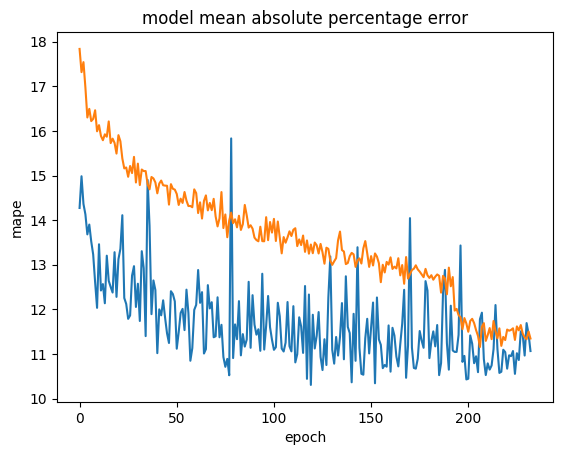

In [25]:
#Plot mape
plt.plot(history.history["val_mape"])
plt.plot(history.history["mape"])
plt.title('model mean absolute percentage error')
plt.ylabel('mape')
plt.xlabel('epoch')
plt.show